# 1. 전처리 부문

## 1.1 기본 라이브러리 입력 

(1) 확장 라이브러리 설치

In [1]:
# 지도 출력 관련 데이터 
!pip install -q geopandas

# 엑셀 관련 데이터 
!pip3 install xlrd
!pip3 install openpyxl

# null 시각화 라이브러리
!pip3 install missingno

(2) 라이브러리 불러오기

In [82]:
# 기본 전처리 라이브러리
import pandas as pd
import numpy as np

import os

# kakao 좌표 관련 요청 라이브러리
import json
import requests

# 지도 표기 library
import folium

#null check library
import missingno as msno

import math

# 시각화
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [91]:
# 한글 폰트 패스로 지정 
import matplotlib.font_manager as fm

path = 'C:\Windows\Fonts\malgunbd.ttf'
font_name = fm.FontProperties(fname=path).get_name()
plt.rc('font', family=font_name)

# 자동 사이즈 조정 
%matplotlib inline

## 1.2 데이터별(전처리)

### 1.2.1 기본 자료 데이터 PATH

In [3]:
path = "./data"
file_list = os.listdir(path)

### 1.2.2 "자동차 등록 자료 통계.xlsx" 관련 자료 전처리

#### 1.2.2.1  한글 제목 변환
엑셀 데이터의 경우 판다스에서 정확하게 잘 처리하지 못하는 경우나 읽기 어려운 경우와 한글의 경우 인코딩 문제가 일부 있어, 관련 부분 제목 변환<p>
    
2020년 01월 자동차 등록자료 통계 --> 2020_01_Car_Info 로 치환

In [4]:
car_file_list = [file for file in file_list if file.endswith('자동차_등록자료_통계.xlsx')]

for car_file in car_file_list:
    src = os.path.join(path, car_file)
    chg_name = car_file.split('_')[0][0:4] + '_' + car_file.split('_')[1][0:-1] + '_' + 'Car_Info' + '.xlsx'
    dst = os.path.join(path, chg_name)
    os.rename(src, dst)

file_list = os.listdir(path)
car_file_list = [file for file in file_list if file.endswith('Car_Info.xlsx')]

변환이 잘되어 파일로 떨어졌는지 확인한다.

In [5]:
print(car_file_list)

['2017_12_Car_Info.xlsx', '2018_01_Car_Info.xlsx', '2018_02_Car_Info.xlsx', '2018_03_Car_Info.xlsx', '2018_04_Car_Info.xlsx', '2018_05_Car_Info.xlsx', '2018_06_Car_Info.xlsx', '2018_07_Car_Info.xlsx', '2018_08_Car_Info.xlsx', '2018_09_Car_Info.xlsx', '2018_10_Car_Info.xlsx', '2018_11_Car_Info.xlsx', '2018_12_Car_Info.xlsx', '2019_01_Car_Info.xlsx', '2019_02_Car_Info.xlsx', '2019_03_Car_Info.xlsx', '2019_04_Car_Info.xlsx', '2019_05_Car_Info.xlsx', '2019_06_Car_Info.xlsx', '2019_07_Car_Info.xlsx', '2019_08_Car_Info.xlsx', '2019_09_Car_Info.xlsx', '2019_10_Car_Info.xlsx', '2019_11_Car_Info.xlsx', '2019_12_Car_Info.xlsx', '2020_01_Car_Info.xlsx', '2020_02_Car_Info.xlsx', '2020_03_Car_Info.xlsx', '2020_04_Car_Info.xlsx', '2020_05_Car_Info.xlsx', '2020_06_Car_Info.xlsx', '2020_07_Car_Info.xlsx', '2020_08_Car_Info.xlsx', '2020_09_Car_Info.xlsx', '2020_10_Car_Info.xlsx']


#### 1.2.1.2 불필요한 데이터 제거 및 2개 데이터로 변환
* 목적 1. 친환경 차량과 비 친환경 차량을 구별하는 인자 추가 
* 목적 2. 불필요 데이터 제거 (의미 없는 값)

(1) 여러개의 엑셀로 분할된 데이터를 한개의 dataframe 으로 합치는 작업

In [6]:
# 각 파일을 1개씩 불러와 전처리 실시 
count = 0
for car_file in car_file_list:
    
    target_file = os.path.join(path, car_file)
    df = pd.read_excel(target_file, engine='openpyxl', sheet_name="10.연료별_등록현황", header = 2)
    df = df.rename(columns={'Unnamed: 2' : '합계'}) # 합계의 경우, 해당 줄에 컬럼명이 없어 추가 함 
    
    if count == 0:
        car_list_df = pd.DataFrame(columns=df.columns)    # 최종 전처리 프레임
        car_list_df['year'] = 0
        car_list_df['month'] = 0
    
    # 소계인 데이터만 추출 (업무용 / 비업무용 등은 제거)
    for i in range(1, len(df) - 17, 17):
        tmp = df[i:i+17].fillna(method='pad')[-1:]
        tmp['year'] = car_file.split('_')[0]
        tmp['month'] = car_file.split('_')[1]
        car_list_df = pd.concat([car_list_df, tmp])
    count += 1

(2) 불필요한 데이터 제거

In [7]:
# 소계 중 한대도 없는 차량의 경우 제거 
car_list_df = car_list_df[car_list_df['계'] != 0.0]

# 불필요한 행 제거 
car_list_df = car_list_df.drop('Unnamed: 21', axis=1)

(3) 친환경 / 비친환경 차량 구분

In [8]:
tmp_lst = list()
for tmp in car_list_df.연료별:
    if (tmp.find('수소') != -1 ) | (tmp.find('전기') != -1):
        tmp_lst.append('친환경')
    else : 
        tmp_lst.append('비친환경')

car_list_df['친환경'] = tmp_lst

(4) 나중에 사용할 것을 대비하여, csv 파일로 생성 해둠 

In [9]:
#csv 형태로 변환 저장 [한글 깨짐 방지를 위해 utf-8 설정]
car_list_df.to_csv(os.path.join(path, 'total_car_info.csv'),mode = 'w',encoding='utf-8-sig')

In [10]:
car_list_df

,연료별,시도별,합계,서울,부산,대구,인천,광주,대전,울산,...,충남,전북,전남,경북,경남,제주,계,year,month,친환경
17,휘발유,소계,계,1600270.0,635449.0,551665.0,673739.0,285769.0,320134.0,275208.0,...,452965.0,358368.0,367161.0,597237.0,777981.0,205253.0,10369752.0,2017,12,비친환경
34,경유,소계,계,1135239.0,535827.0,458852.0,656260.0,262201.0,253864.0,221735.0,...,497950.0,422783.0,499841.0,638956.0,717127.0,215321.0,9576395.0,2017,12,비친환경
51,엘피지,소계,계,301546.0,125327.0,122326.0,145392.0,87891.0,72792.0,40227.0,...,88184.0,96526.0,107845.0,132454.0,145109.0,63027.0,2104675.0,2017,12,비친환경
68,등유,소계,계,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2017,12,비친환경
85,전기,소계,계,4797.0,816.0,2005.0,542.0,548.0,303.0,356.0,...,336.0,336.0,960.0,756.0,1022.0,9206.0,25108.0,2017,12,친환경
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,하이브리드(LPG+전기),소계,계,1835.0,808.0,933.0,764.0,679.0,537.0,513.0,...,753.0,839.0,886.0,1066.0,1078.0,343.0,16488.0,2020,10,친환경
221,하이브리드(CNG+전기),소계,계,51.0,2.0,13.0,39.0,26.0,0.0,46.0,...,0.0,8.0,0.0,31.0,1.0,0.0,326.0,2020,10,친환경
255,수소,소계,계,1431.0,858.0,61.0,448.0,653.0,479.0,1721.0,...,442.0,342.0,108.0,15.0,856.0,0.0,10041.0,2020,10,친환경
272,기타연료,소계,계,6236.0,15355.0,3831.0,12402.0,3517.0,3239.0,4845.0,...,8074.0,4595.0,8835.0,9686.0,8127.0,756.0,124678.0,2020,10,비친환경


### 1.2.3 수소 충전소 위치 데이터 처리  (hyd_charging_df)

* 목표 1. 주소지를 다른 데이터와 합칠수 있게 시 / 도별로 나눈 데이터를 추가한다.
* 목표 2. 지도로 표시할수 있도록 좌표 값을 kakao api를 활용하여 추가한다.

In [11]:
path = "./data"
target_file = os.path.join(path, 'Hydrogen_chariging_station.csv')
hyd_charging_df = pd.read_csv(target_file, encoding='cp949')

In [12]:
hyd_charging_df

,No,충전소명,구분,공급방식,주소,충전소전화번호,용도,비고
0,1,현대자동차㈜ 환경기술연구소,저장식,튜브트레일러,경기 용인 기흥 마북로240번길 17-5(마북동),031-899-3022,연구용,NaN
1,2,한국가스공사 H2/HCNG복합충전소,제조식,개질(NG),인천 연수구 인천신항대로 960,032-810-0388,연구용,미가동
2,3,현대자동차㈜ 남양연구소,저장식,튜브트레일러,경기 화성 현대연구소로 150,NaN,연구용,NaN
3,4,에스앤디㈜-울산수소충전소,저장식,튜브트레일러,울산 남구 장생포고래로 317,052-226-6000,연구용,휴지
4,5,한국교통안전공단 자동차성능연구소,저장식,튜브트레일러,경기 화성 송산면 삼존로 200,031-369-1173,연구용,미가동
5,6,현대자동차㈜ 양재그린에너지스테이션,저장식,튜브트레일러,서울 서초구 바우뫼로12길 73,02-2058-1351,상업용,휴지
6,7,서울특별시 상암수소스테이션,제조식,개질(NG+매립가스),서울 마포구 하늘공원로 86,02-3151-0336,상업용,NaN
7,8,한국에너지기술연구원,제조식,수전해,전북 부안군 하서면 신재생에너지로 20-41,063-580-1670,연구용,휴지
8,9,㈜덕양 매암수소충전소,저장식,튜브트레일러,울산 남구 장생포고래로29번길 5,070-4421-1688,상업용,NaN
9,10,이엠솔루션㈜ 대구경북지점,제조식,수전해,대구 북구 조야로2길 41,055-239-9026,상업용,휴지


#### (1) 주소지를 분리한다. 
<p>주소지는 2가지 특징을 지니고 있다.</p>
<ol> 
    <li> 도에 속한 주소는 2가지 값을 지닌다.</li>
    <li> 시에 속한 주소는 1가지 값을 지닌다. </li>
</ol>
다른 데이터를 기준으로 시도 , 지역 구분으로 나누어 표기하기에 동일하게 표기한다. 

In [13]:
tmp_city = list()
tmp_location = list()
for address in hyd_charging_df.주소:
    tmp =  address.split()
    if tmp[0] in ('경기', '경기도', '강원', '강원도', '충남', '충북', '경남', '경북', '전북', '전남' ):
        tmp_city.append(tmp[0].replace('도', '').replace('시', ''))
        tmp_location.append(tmp[1].replace('시', '').replace('군', ''))
    else : 
        tmp_city.append(tmp[0].replace('시', '').replace('군', ''))
        tmp_location.append(tmp[0].replace('시', '').replace('군', ''))            

hyd_charging_df['시도'] = tmp_city
hyd_charging_df['지역'] = tmp_location

In [14]:
hyd_charging_df

,No,충전소명,구분,공급방식,주소,충전소전화번호,용도,비고,시도,지역
0,1,현대자동차㈜ 환경기술연구소,저장식,튜브트레일러,경기 용인 기흥 마북로240번길 17-5(마북동),031-899-3022,연구용,NaN,경기,용인
1,2,한국가스공사 H2/HCNG복합충전소,제조식,개질(NG),인천 연수구 인천신항대로 960,032-810-0388,연구용,미가동,인천,인천
2,3,현대자동차㈜ 남양연구소,저장식,튜브트레일러,경기 화성 현대연구소로 150,NaN,연구용,NaN,경기,화성
3,4,에스앤디㈜-울산수소충전소,저장식,튜브트레일러,울산 남구 장생포고래로 317,052-226-6000,연구용,휴지,울산,울산
4,5,한국교통안전공단 자동차성능연구소,저장식,튜브트레일러,경기 화성 송산면 삼존로 200,031-369-1173,연구용,미가동,경기,화성
5,6,현대자동차㈜ 양재그린에너지스테이션,저장식,튜브트레일러,서울 서초구 바우뫼로12길 73,02-2058-1351,상업용,휴지,서울,서울
6,7,서울특별시 상암수소스테이션,제조식,개질(NG+매립가스),서울 마포구 하늘공원로 86,02-3151-0336,상업용,NaN,서울,서울
7,8,한국에너지기술연구원,제조식,수전해,전북 부안군 하서면 신재생에너지로 20-41,063-580-1670,연구용,휴지,전북,부안
8,9,㈜덕양 매암수소충전소,저장식,튜브트레일러,울산 남구 장생포고래로29번길 5,070-4421-1688,상업용,NaN,울산,울산
9,10,이엠솔루션㈜ 대구경북지점,제조식,수전해,대구 북구 조야로2길 41,055-239-9026,상업용,휴지,대구,대구


#### (2) 위도 경도 추가하기

위도 경도는 주소지로 나온 정보를 kakao api를 활용하여 검색한 후 위도 경도를 획득한다. <p>
    
참고 URL : https://medium.com/@john_analyst/%ED%8C%8C%EC%9D%B4%EC%8D%AC%EC%9D%84-%ED%99%9C%EC%9A%A9%ED%95%9C-%EC%B9%B4%EC%B9%B4%EC%98%A4-api%EB%A1%9C-%EC%9C%84%EA%B2%BD%EB%8F%84-%EA%B5%AC%ED%95%98%EA%B8%B0-69bc51697753

RestAPI=	0f187fa9603bee6f574b613cdb8f525d <p>
code=OLlwbTIfs9G7Nxo1CWhVsLBftdt-dflEMvkxyqHa7AkMnlItQ45L700dPPRbTs6oWKhxpQo9dZsAAAF2JwbVTg <p>

https://kauth.kakao.com/oauth/token?grant_type=authorization_code&client_id=0f187fa9603bee6f574b613cdb8f525d&redirect_uri=http://localhost:8888&code=OLlwbTIfs9G7Nxo1CWhVsLBftdt-dflEMvkxyqHa7AkMnlItQ45L700dPPRbTs6oWKhxpQo9dZsAAAF2JwbVTg

KAKAO API auth 인증 성공
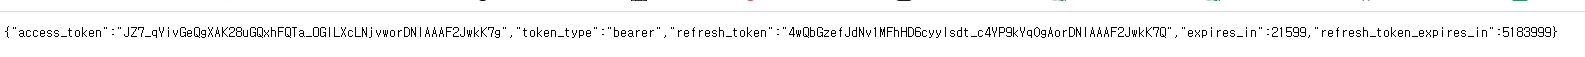

In [15]:
def getLatLng(addr):
    url = 'https://dapi.kakao.com/v2/local/search/address.json?query=' + addr
    headers = {"Authorization": "KakaoAK 073a393656181c6073880062d3507191"}
    result = json.loads(str(requests.get(url, headers=headers).text))
    match_first = result['documents'][0]['address']
    return float(match_first['y']), float(match_first['x'])

location = getLatLng('서울 마포구 모래내로1길 20')

<b>위도 경도 획득 테스트</b>

In [16]:
print(location[0], location[1])

37.5656948713242 126.903284318892


##### 1) 전체 경로가  좌표 변환 되지 않아 불가한 주소는 근처 지역으로 수동 변환한다.

이를 위해, 불가한 좌표만 exception 으로 받아내어 확인한다.

In [17]:
latitude_lst = list()
longitude_lst = list()
falut_location = list()
for i in range(len(hyd_charging_df.주소)):
    try:
        location = getLatLng(hyd_charging_df.주소[i])
        latitude_lst.append(location[0])
        longitude_lst.append(location[1])
    except Exception as e:
        falut_location.append((i, hyd_charging_df.주소[i]))

In [18]:
falut_location

[(1, '인천 연수구 인천신항대로 960'), (9, '대구 북구 조야로2길 41')]

##### 2) 아래 경로의 대해서는 구글 검색을 통해 변환한다. (정확한 주소가 없음으로)
인천 연수구 인천신항대로 960 --> 인천 연수구 인천신항대로 950 <p>
대구 북구 조야로2길 41 --> 대구 북구 조야로2길 55 <p>

In [19]:
location = getLatLng('인천 연수구 인천신항대로 950')
latitude_lst.insert(falut_location[0][0],location[0])
longitude_lst.insert(falut_location[0][0],location[1])

In [20]:
location = getLatLng('대구 북구 조야로2길 55')
latitude_lst.insert(falut_location[1][0],location[0])
longitude_lst.insert(falut_location[1][0],location[1])

In [21]:
latitude_lst[0] , longitude_lst[0]

(37.307586522662, 127.135662910913)

In [22]:
hyd_charging_df['위도'] = latitude_lst
hyd_charging_df['경도'] = longitude_lst

In [23]:
hyd_charging_df

,No,충전소명,구분,공급방식,주소,충전소전화번호,용도,비고,시도,지역,위도,경도
0,1,현대자동차㈜ 환경기술연구소,저장식,튜브트레일러,경기 용인 기흥 마북로240번길 17-5(마북동),031-899-3022,연구용,NaN,경기,용인,37.307587,127.135663
1,2,한국가스공사 H2/HCNG복합충전소,제조식,개질(NG),인천 연수구 인천신항대로 960,032-810-0388,연구용,미가동,인천,인천,37.351717,126.613254
2,3,현대자동차㈜ 남양연구소,저장식,튜브트레일러,경기 화성 현대연구소로 150,NaN,연구용,NaN,경기,화성,37.159398,126.813525
3,4,에스앤디㈜-울산수소충전소,저장식,튜브트레일러,울산 남구 장생포고래로 317,052-226-6000,연구용,휴지,울산,울산,35.507446,129.383761
4,5,한국교통안전공단 자동차성능연구소,저장식,튜브트레일러,경기 화성 송산면 삼존로 200,031-369-1173,연구용,미가동,경기,화성,37.228653,126.768241
5,6,현대자동차㈜ 양재그린에너지스테이션,저장식,튜브트레일러,서울 서초구 바우뫼로12길 73,02-2058-1351,상업용,휴지,서울,서울,37.468378,127.034374
6,7,서울특별시 상암수소스테이션,제조식,개질(NG+매립가스),서울 마포구 하늘공원로 86,02-3151-0336,상업용,NaN,서울,서울,37.571598,126.881674
7,8,한국에너지기술연구원,제조식,수전해,전북 부안군 하서면 신재생에너지로 20-41,063-580-1670,연구용,휴지,전북,부안,35.712072,126.599258
8,9,㈜덕양 매암수소충전소,저장식,튜브트레일러,울산 남구 장생포고래로29번길 5,070-4421-1688,상업용,NaN,울산,울산,35.509879,129.367415
9,10,이엠솔루션㈜ 대구경북지점,제조식,수전해,대구 북구 조야로2길 41,055-239-9026,상업용,휴지,대구,대구,35.907818,128.583034


#### 3) 실제 지도상 해당 위치를 표기 한다.

In [24]:
# 지도 시작 지점을 주기 위해서
lat = hyd_charging_df['위도'].mean()
long = hyd_charging_df['경도'].mean()

m = folium.Map([lat,long], zoom_start=7)

for i in range(len(hyd_charging_df)):
    lat = hyd_charging_df.loc[i,'위도']
    loc = hyd_charging_df.loc[i,'경도']
    title = hyd_charging_df.loc[i,'충전소명']
    
    folium.Marker([lat, loc], tooltip=title).add_to(m)

# 한글 확인이 필요한 경우 아래 html 확인
m.save('hyd_charging_location.html')
m

### 1.2.4 올해 수소차의 구매 동향 데이터(hyd_supply_df)

<b>본 데이터의 가공 사항</b>
<ol>
    <li> NULL DATA 제거</li>    
    <li> 차종에 따른 분류 데이터를 1개의 데이터로 변환한다.</li>    
    <li> 지역 구분 데이터 상 특별시 , 광역시 등을 제외한다.</li>
</ol>

In [25]:
path = "./data"
target_file = os.path.join(path, 'Hydrogen_car_supply_status.csv')
hyd_supply_df = pd.read_csv(target_file)

In [26]:
hyd_supply_df

,시도,지역구분,차종,민간공고대수,접수대수,출고대수,출고잔여대수
0,서울,서울특별시,승용,1211,1013.0,894.0,317.0
1,서울,서울특별시,승합,4,4.0,0.0,4.0
2,부산,부산광역시,승용,400,345.0,335.0,65.0
3,부산,부산광역시,승합,15,5.0,0.0,15.0
4,대구,대구광역시,전체,50,56.0,50.0,0.0
...,...,...,...,...,...,...,...
81,NaN,NaN,NaN,NaN,NaN,NaN,NaN
82,NaN,NaN,NaN,NaN,NaN,NaN,NaN
83,NaN,NaN,NaN,NaN,NaN,NaN,NaN
84,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### 1) 아예 data 상 null 인 데이터 제거

In [27]:
hyd_supply_df = hyd_supply_df[hyd_supply_df.시도.notnull()]

In [28]:
hyd_supply_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77 entries, 0 to 76
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   시도      77 non-null     object 
 1   지역구분    77 non-null     object 
 2   차종      77 non-null     object 
 3   민간공고대수  77 non-null     object 
 4   접수대수    77 non-null     float64
 5   출고대수    77 non-null     float64
 6   출고잔여대수  77 non-null     float64
dtypes: float64(3), object(4)
memory usage: 4.8+ KB


In [29]:
hyd_supply_df['민간공고대수'] = hyd_supply_df['민간공고대수'].astype('float')

<ipython-input-29-7ef014515d82>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hyd_supply_df['민간공고대수'] = hyd_supply_df['민간공고대수'].astype('float')


#### 2) 차종 구분을 없애고 하나의 데이터로 만든다.

In [30]:
hyd_supply_df = hyd_supply_df.groupby(['시도','지역구분']).sum()
hyd_supply_df

민간공고대수   접수대수   출고대수  출고잔여대수
시도 지역구분                              
강원 고성군      4.0    4.0    4.0     0.0
   동해시     10.0   10.0   10.0     0.0
   삼척시    169.0  180.0  169.0     0.0
   속초시    127.0  104.0   90.0    37.0
   원주시     50.0   50.0   50.0     0.0
...         ...    ...    ...     ...
충북 괴산군     30.0    4.0    0.0    30.0
   음성군    145.0   17.0   16.0   129.0
   제천시    100.0    6.0    6.0    94.0
   청주시    287.0  134.0  131.0   156.0
   충주시    100.0   34.0   34.0    66.0

[75 rows x 4 columns]

In [31]:
hyd_supply_df.reset_index(level=['시도','지역구분'], inplace = True)

In [32]:
hyd_supply_df

,시도,지역구분,민간공고대수,접수대수,출고대수,출고잔여대수
0,강원,고성군,4.0,4.0,4.0,0.0
1,강원,동해시,10.0,10.0,10.0,0.0
2,강원,삼척시,169.0,180.0,169.0,0.0
3,강원,속초시,127.0,104.0,90.0,37.0
4,강원,원주시,50.0,50.0,50.0,0.0
...,...,...,...,...,...,...
70,충북,괴산군,30.0,4.0,0.0,30.0
71,충북,음성군,145.0,17.0,16.0,129.0
72,충북,제천시,100.0,6.0,6.0,94.0
73,충북,청주시,287.0,134.0,131.0,156.0


#### 3) 시 / 도 / 군등의 데이터를 제거한다.

본 데이터의 특징은, 경기, 경북 등의 도가 들어가지 않은 데이터의 경우 시도를 그대로 사용하면 지역구분에서 제거가 된다.<p>
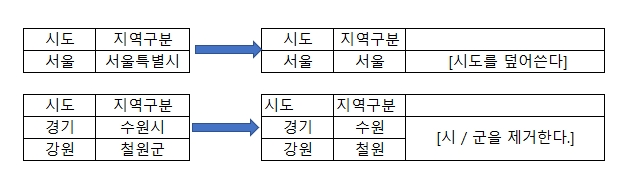

In [33]:
tmp_location = list()
for i in range(len(hyd_supply_df)):
    if hyd_supply_df.loc[i, '시도'] in ('경기', '경기도', '강원', '강원도', '충남', '충북', '경남', '경북', '전북', '전남' ):
        tmp_location.append(hyd_supply_df.loc[i, '지역구분'][:-1])
    else :
        tmp_location.append(hyd_supply_df.loc[i, '시도'])

hyd_supply_df['지역구분'] = tmp_location

In [34]:
hyd_supply_df.head(5)

,시도,지역구분,민간공고대수,접수대수,출고대수,출고잔여대수
0,강원,고성,4.0,4.0,4.0,0.0
1,강원,동해,10.0,10.0,10.0,0.0
2,강원,삼척,169.0,180.0,169.0,0.0
3,강원,속초,127.0,104.0,90.0,37.0
4,강원,원주,50.0,50.0,50.0,0.0


### 1.2.4 전기 충전소 현황 데이터 (elec_charging_station_df)

<b>본 데이터의 가공 사항</b>
<ol>
    <li> 이상 행 관련 행 명칭 변경 </li>    
    <li> 결측치 가공 (제거 / 추가)</li>    
    <li> 지역 구분을 세부에서 시도 수준 추가</li>
</ol>

In [35]:
path = "./data"
target_file = os.path.join(path, 'ELEC_Charging_station.csv')
elec_charging_station_df = pd.read_csv(target_file, encoding='cp949')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3641 entries, 0 to 3640
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   충전소ID   3641 non-null   int64  
 1   충전소명    3641 non-null   object 
 2   충전소주소   3600 non-null   object 
 3   상세주소    3571 non-null   object 
 4   위도      3597 non-null   float64
 5   위도.1    3597 non-null   float64
 6   이용가능시간  3569 non-null   object 
 7   연락처     3611 non-null   object 
dtypes: float64(2), int64(1), object(5)
memory usage: 227.7+ KB


<AxesSubplot:>

C:\Users\kerne\.conda\envs\geo_env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 52649 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\kerne\.conda\envs\geo_env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 51204 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\kerne\.conda\envs\geo_env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 49548 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\kerne\.conda\envs\geo_env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 47749 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\kerne\.conda\envs\geo_env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 51452 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\kerne\.conda\envs\geo_env\lib\site-packages\matplotlib\backends\ba

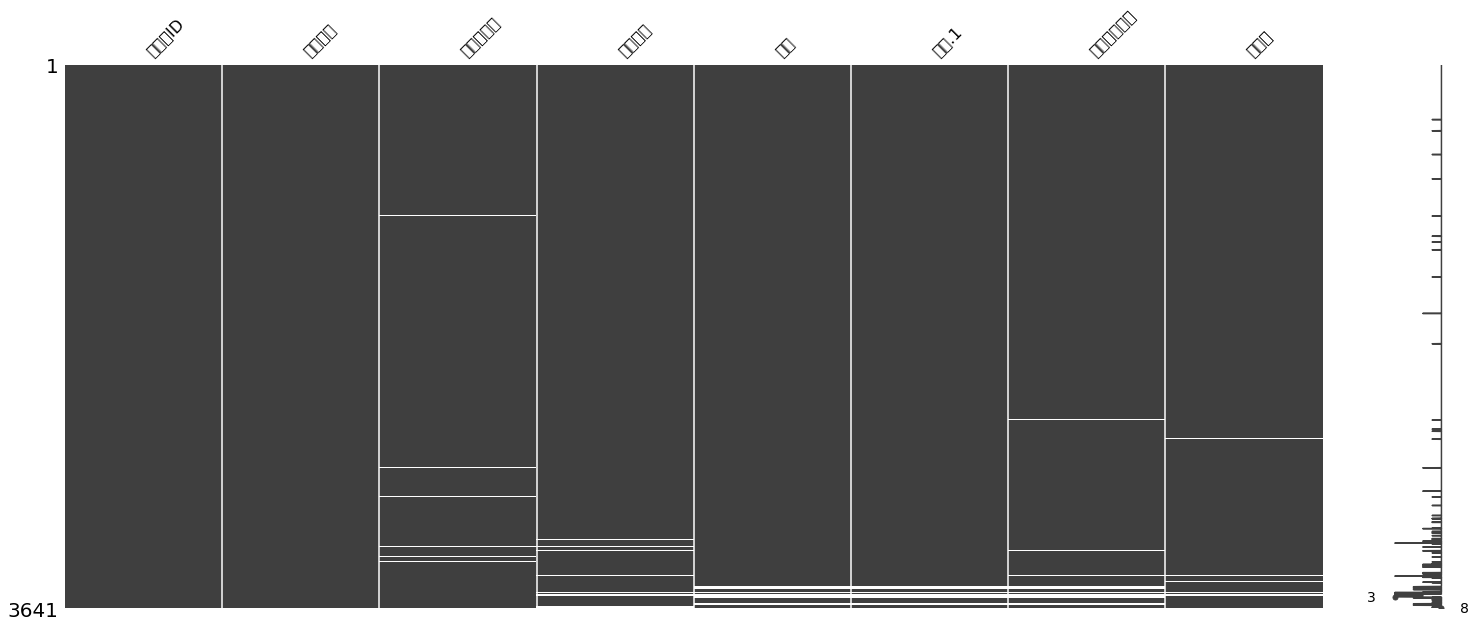

In [36]:
elec_charging_station_df.info()

msno.matrix(elec_charging_station_df)

데이터상 결측치 3구간을 처리해야함을 확인할 수 있다. <p>
1. 충전소주소
2. 위도 / 경도

#### 1) 위도.1 (x) -> 경도로 column 변경

In [37]:
elec_charging_station_df = elec_charging_station_df.rename(columns={'위도.1' : '경도'})
elec_charging_station_df.head(3)

,충전소ID,충전소명,충전소주소,상세주소,위도,경도,이용가능시간,연락처
0,2891,역삼래미안,서울 강남구 역삼동 757,지하2층 107동 3-4라인,37.497198,127.050153,24시간,1899-2100
1,2892,현대까르띠에710아파트,서울 강남구 역삼동 710,지하주차장 진입 후 바로 좌측,37.501522,127.044931,24시간,1899-2100
2,2904,열매마을5단지,대전광역시 유성구 지족동 877,지하주차장,36.377466,127.319577,24시간,1899-2100


In [38]:
elec_charging_station_df.columns

Index(['충전소ID', '충전소명', '충전소주소', '상세주소', '위도', '경도', '이용가능시간', '연락처'], dtype='object')

#### 2) 결측치 가공 (제거 / 추가)

<b>1. 주소 상 결측치의 경우, 위도 경도를 주소로 변환하여, 판단하는 방법도 있다고 생각하나, 데이터 정확성 검토의 시간이 다소 오래걸려 제거한다. </b>

In [39]:
elec_charging_station_df.충전소주소.isnull().value_counts()

False    3600
True       41
Name: 충전소주소, dtype: int64

In [40]:
elec_charging_station_df = elec_charging_station_df[elec_charging_station_df.충전소주소.notnull()]

In [41]:
elec_charging_station_df.충전소주소.isnull().value_counts()

False    3600
Name: 충전소주소, dtype: int64

<b>2. 위도 경도가 없는 대상의 값 변경 </b>

위도 경도가 없는 대상의 경우, 우선은 충전소 주소로 위치를 판단하고, 해당 부분도 판단이 불가한 경우 제거하기로 한다.

In [42]:
not_found_idx_lst = list()
for i in elec_charging_station_df.index:
    if math.isnan(elec_charging_station_df.loc[i,'경도']):
        try:
            location = getLatLng(elec_charging_station_df.충전소주소[i])
            elec_charging_station_df.loc[i,'위도'] = location[0]
            elec_charging_station_df.loc[i,'경도'] = location[1]
        except Exception as e:
            not_found_idx_lst.append(i)

elec_charging_station_df = elec_charging_station_df.drop(not_found_idx_lst)

In [43]:
elec_charging_station_df

,충전소ID,충전소명,충전소주소,상세주소,위도,경도,이용가능시간,연락처
0,2891,역삼래미안,서울 강남구 역삼동 757,지하2층 107동 3-4라인,3.749720e+01,1.270502e+02,24시간,1899-2100
1,2892,현대까르띠에710아파트,서울 강남구 역삼동 710,지하주차장 진입 후 바로 좌측,3.750152e+01,1.270449e+02,24시간,1899-2100
2,2904,열매마을5단지,대전광역시 유성구 지족동 877,지하주차장,3.637747e+01,1.273196e+02,24시간,1899-2100
3,2906,서진아파트,경상남도 창원시 마산회원구 내서읍 상곡리 67,지하1층주차장,3.524164e+01,1.285043e+02,24시간,1899-2100
4,2907,팜스프링아파트,경기도 파주시 금촌동 7,119동 지하3층 B33,3.777181e+01,1.267753e+02,24시간,1899-2100
...,...,...,...,...,...,...,...,...
3636,4123,단양군청,충청북도 단양군 단양읍 별곡리 300,NaN,3.300000e+01,1.240000e+02,24시간,1899-2100
3637,4128,가경벽산아파트,충청북도 청주시 흥덕구 가경동 762,NaN,3.300000e+01,1.240000e+02,24시간,1899-2100
3638,4106,화도수동행정복지센터,경기도 남양주시 화도읍 마석우리 548,옥외주차장,3.739262e+06,1.271804e+07,24시간,1899-2100
3639,4125,음성군 근로자종합복지관,충청북도 음성군 대소면 태생리 605,NaN,3.300000e+01,1.240000e+02,24시간,1899-2100


## 3) 지역 구분을 세부데이터를 바탕으로 시도 수준 추가 

#### 데이터 값 확인

In [44]:
tmp = list()
for i in elec_charging_station_df.index:
    address = elec_charging_station_df.loc[i, '충전소주소']
    tmp.append(address.split()[0])

tmp = set(tmp)
print(tmp)

{'부산', '충남', '충북', '경기도', '풍산동', '충청남도', '충청북도', '서울시', '경북', '경기', '강원', '울산', '다산동', '대전광역시', '서울특별시', '서울', '대구', '대전', '경상남도', '전라북도', '전남', '인천광역시', '제주특별자치도', '울산광역시', '부산광역시', '대구광역시', '전라남도', '경상북도', '광주광역시', '강원도', '인천', '광주', '전북', '부산시', '세종특별자치시', '경남'}


시도 데이터 가공 <p>
 기존 양식과 동일하게 데이터 가공 

In [45]:
tmp = list()
for i in elec_charging_station_df.index:
    address = elec_charging_station_df.loc[i, '충전소주소'].split()
    if address[0] in ('경기도', '강원도'):
        tmp.append(address[0][:-1])
    elif address[0] in ('경상남도', '경상북도', '충청남도', '충청북도', '전라남도', '전라북도'):
        tmp.append(address[0][0::2])
    elif address[0] in ('경남', '경북', '충남', '충북', '전남', '전북', '강원', '경기'):
        tmp.append(address[0])
    else:
        tmp.append(address[0][:2])

elec_charging_station_df['시도'] = tmp
print(set(tmp))

{'부산', '제주', '세종', '충북', '경남', '경북', '경기', '울산', '강원', '다산', '대구', '서울', '대전', '전남', '풍산', '인천', '전북', '광주', '충남'}


도시명 내의 다산과 풍산의 경우 시의 이름이 제외되어 있는 것으로 추정됨 <p>

이에 따라, 이의 대한 처리는 우선적으로는 제거 하는 방향으로 수행

In [46]:
elec_charging_station_df = elec_charging_station_df[(elec_charging_station_df['시도'] != '다산') & (elec_charging_station_df['시도'] != '풍산')]
elec_charging_station_df

,충전소ID,충전소명,충전소주소,상세주소,위도,경도,이용가능시간,연락처,시도
0,2891,역삼래미안,서울 강남구 역삼동 757,지하2층 107동 3-4라인,3.749720e+01,1.270502e+02,24시간,1899-2100,서울
1,2892,현대까르띠에710아파트,서울 강남구 역삼동 710,지하주차장 진입 후 바로 좌측,3.750152e+01,1.270449e+02,24시간,1899-2100,서울
2,2904,열매마을5단지,대전광역시 유성구 지족동 877,지하주차장,3.637747e+01,1.273196e+02,24시간,1899-2100,대전
3,2906,서진아파트,경상남도 창원시 마산회원구 내서읍 상곡리 67,지하1층주차장,3.524164e+01,1.285043e+02,24시간,1899-2100,경남
4,2907,팜스프링아파트,경기도 파주시 금촌동 7,119동 지하3층 B33,3.777181e+01,1.267753e+02,24시간,1899-2100,경기
...,...,...,...,...,...,...,...,...,...
3636,4123,단양군청,충청북도 단양군 단양읍 별곡리 300,NaN,3.300000e+01,1.240000e+02,24시간,1899-2100,충북
3637,4128,가경벽산아파트,충청북도 청주시 흥덕구 가경동 762,NaN,3.300000e+01,1.240000e+02,24시간,1899-2100,충북
3638,4106,화도수동행정복지센터,경기도 남양주시 화도읍 마석우리 548,옥외주차장,3.739262e+06,1.271804e+07,24시간,1899-2100,경기
3639,4125,음성군 근로자종합복지관,충청북도 음성군 대소면 태생리 605,NaN,3.300000e+01,1.240000e+02,24시간,1899-2100,충북


<b>시도 부문 데이터 가공. </b>

In [47]:
elec_charging_station_df.head(3)

,충전소ID,충전소명,충전소주소,상세주소,위도,경도,이용가능시간,연락처,시도
0,2891,역삼래미안,서울 강남구 역삼동 757,지하2층 107동 3-4라인,37.497198,127.050153,24시간,1899-2100,서울
1,2892,현대까르띠에710아파트,서울 강남구 역삼동 710,지하주차장 진입 후 바로 좌측,37.501522,127.044931,24시간,1899-2100,서울
2,2904,열매마을5단지,대전광역시 유성구 지족동 877,지하주차장,36.377466,127.319577,24시간,1899-2100,대전


In [48]:
tmp = list()
for i in elec_charging_station_df.index:
    address = elec_charging_station_df.loc[i, '충전소주소']
    tmp.append(address.split()[1])

tmp = set(tmp)
print(tmp)

{'김포시', '영주시', '진안군', '진주시', '장흥군', '동구', '수성구', '달성군', '양구군', '연천군', '진도군', '횡성군', '한강대로', '원주시', '파주시', '은평구', '서귀포시', '함평군', '소담동', '용산구', '광주시', '화천군', '아산시', '기장군', '구미시', '강화군', '부산진구', '장수군', '영월군', '계양구', '인제군', '영도구', '상주시', '의왕시', '청주시', '양평군', '도봉구', '고양시', '증평군', '고성읍', '수원시', '과천시', '순창군', '대덕구', '정읍시', '도담동', '사상구', '영동군', '동작구', '예산군', '태백시', '완주군', '나성동', '남동구', '통영시', '함양군', '군포시', '무주군', '영천시', '영양군', '계룡시', '영등포구', '군산시', '괴산군', '절재로', '사하구', '청도군', '하남시', '여수시', '익산시', '강진군', '음성군', '사천시', '구리시', '김제시', '대저1동', '성주군', '노원구', '천안시', '밀양시', '곡성군', '포항시', '남양주시', '춘천시', '구례군', '광산구', '서산시', '금산군', '보성군', '안성시', '중랑구', '중구', '철원군', '해운대구', '광진구', '광명시', '조치원읍', '성남시', '충주시', '고창군', '청양군', '담양군', '양주시', '대평동', '고운동', '서대문구', '해남군', '태안군', '동해시', '여주시', '연제구', '평택시', '산청군', '울주군', '북구', '부천시', '홍성군', '전주시', '수영구', '공주시', '한솔동', '안동시', '고성군', '정선군', '당진시', '진천군', '동두천시', '목포시', '고령군', '제천시', '부여군', '양천구', '용인시', '합천군', '창원시', '속초시', '하동군', '강동구', '안양시', '성북구', '남해군', '완도군'

In [49]:
tmp = list()
for i in elec_charging_station_df.index:
    address = elec_charging_station_df.loc[i, '시도']
    if address in ('경남', '경북', '충남', '충북', '전남', '전북', '강원', '경기'):
        tmp.append(elec_charging_station_df.loc[i, '충전소주소'].split()[1][:-1])
    else:
        tmp.append(address)

elec_charging_station_df['지역구분'] = tmp
print(set(tmp))

{'군포', '부산', '남원', '제주', '옥천', '예천', '경주', '구리', '완주', '증평', '사천', '청양', '대구', '구례', '광명', '양구', '대전', '순창', '의정부', '무안', '서산', '여주', '영천', '순천', '통영', '완도', '고창', '창녕', '김천', '함안', '포항', '공주', '횡성', '용인', '고양', '평창', '장성', '청송', '진천', '상주', '영월', '철원', '안산', '제천', '이천', '인제', '보은', '속초', '임실', '양산', '장수', '화천', '의령', '괴산', '칠곡', '송산', '합천', '평택', '가평', '영양', '광양', '고흥', '김제', '화성', '청도', '강릉', '충주', '인천', '양평', '고령', '안성', '부여', '천안', '부안', '경산', '울진', '세종', '원주', '아산', '함양', '산청', '당진', '성남', '영주', '익산', '울산', '오산', '영광', '서천', '청주', '서울', '고성', '군산', '곡성', '파주', '진안', '김해', '태백', '영암', '거제', '태안', '문경', '계룡', '양양', '장흥', '예산', '해남', '정읍', '구미', '포천', '논산', '영동', '여수', '함평', '하동', '음성', '담양', '목포', '전주', '연천', '시흥', '안양', '거창', '홍성', '남양주', '홍천', '삼척', '하남', '의왕', '동두천', '진도', '과천', '단양', '진주', '영덕', '양주', '수원', '화순', '남해', '정선', '동해', '보령', '창원', '금산', '안동', '신안', '무주', '성주', '나주', '부천', '강진', '광주', '의성', '김포', '밀양', '보성', '춘천'}


<ipython-input-49-9f23962a28d1>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  elec_charging_station_df['지역구분'] = tmp


### 최종 데이터 결과

In [50]:
elec_charging_station_df

,충전소ID,충전소명,충전소주소,상세주소,위도,경도,이용가능시간,연락처,시도,지역구분
0,2891,역삼래미안,서울 강남구 역삼동 757,지하2층 107동 3-4라인,3.749720e+01,1.270502e+02,24시간,1899-2100,서울,서울
1,2892,현대까르띠에710아파트,서울 강남구 역삼동 710,지하주차장 진입 후 바로 좌측,3.750152e+01,1.270449e+02,24시간,1899-2100,서울,서울
2,2904,열매마을5단지,대전광역시 유성구 지족동 877,지하주차장,3.637747e+01,1.273196e+02,24시간,1899-2100,대전,대전
3,2906,서진아파트,경상남도 창원시 마산회원구 내서읍 상곡리 67,지하1층주차장,3.524164e+01,1.285043e+02,24시간,1899-2100,경남,창원
4,2907,팜스프링아파트,경기도 파주시 금촌동 7,119동 지하3층 B33,3.777181e+01,1.267753e+02,24시간,1899-2100,경기,파주
...,...,...,...,...,...,...,...,...,...,...
3636,4123,단양군청,충청북도 단양군 단양읍 별곡리 300,NaN,3.300000e+01,1.240000e+02,24시간,1899-2100,충북,단양
3637,4128,가경벽산아파트,충청북도 청주시 흥덕구 가경동 762,NaN,3.300000e+01,1.240000e+02,24시간,1899-2100,충북,청주
3638,4106,화도수동행정복지센터,경기도 남양주시 화도읍 마석우리 548,옥외주차장,3.739262e+06,1.271804e+07,24시간,1899-2100,경기,남양주
3639,4125,음성군 근로자종합복지관,충청북도 음성군 대소면 태생리 605,NaN,3.300000e+01,1.240000e+02,24시간,1899-2100,충북,음성


# 2. 데이터 탐색 (EDA)

<h3>주요 데이터 정보</h3>
<ul>
    <li> car_list_df : 차량 등록 현황 DF [2017.12 ~ 2020.10] </li>
    <li> hyd_charging_df : 수소 충전소 위치 DF [2020.10] </li>
    <li> hyd_supply_df : 수소 자동차 구매현황 및 수요 [2020.10] </li>
    <li> elec_charging_station_df : 전기자동차 충전소 위치 DF [2020.09]</li>
</ul>

<h3> 데이터의 주요 join 컬럼 <h3>
 [ 시도 , 지역 구분 활용]

## 2.1 단일 데이터 프레임 탐색

### 2.1.1 차량 구매현황 (car_list_df)

#### 산출 예상 자료
 - 최근 3개년간 차량 구매 동향
 - 3개년간 친환경 차량의 구매 비중 
 - 지역별 친환경 차량 구매 비율
 - 친환경 차량 중 수소차가 차지하는 비중

In [51]:
car_list_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 547 entries, 17 to 289
Data columns (total 24 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   연료별     547 non-null    object 
 1   시도별     547 non-null    object 
 2   합계      547 non-null    object 
 3   서울      547 non-null    float64
 4   부산      547 non-null    float64
 5   대구      547 non-null    float64
 6   인천      547 non-null    float64
 7   광주      547 non-null    float64
 8   대전      547 non-null    float64
 9   울산      547 non-null    float64
 10  세종      547 non-null    float64
 11  경기      547 non-null    float64
 12  강원      547 non-null    float64
 13  충북      547 non-null    float64
 14  충남      547 non-null    float64
 15  전북      547 non-null    float64
 16  전남      547 non-null    float64
 17  경북      547 non-null    float64
 18  경남      547 non-null    float64
 19  제주      547 non-null    float64
 20  계       547 non-null    float64
 21  year    547 non-null    object 
 22  m

In [52]:
car_list_df.describe()

,서울,부산,대구,인천,광주,대전,울산,세종,경기,강원,충북,충남,전북,전남,경북,경남,제주,계
count,5.470000e+02,5.470000e+02,5.470000e+02,5.470000e+02,547.000000,547.000000,547.000000,547.000000,5.470000e+02,547.000000,547.000000,5.470000e+02,547.000000,5.470000e+02,5.470000e+02,5.470000e+02,547.000000,5.470000e+02
mean,4.001185e+05,1.765504e+05,1.514074e+05,2.046227e+05,85696.720293,85960.095064,71901.100548,19660.054845,7.259342e+05,99073.001828,105582.171846,1.412535e+05,117852.965265,1.332492e+05,1.832670e+05,2.187418e+05,72586.164534,2.993457e+06
std,8.479612e+05,3.731446e+05,3.192326e+05,4.328331e+05,179192.027034,181357.818057,153218.301046,41831.798217,1.543898e+06,210638.336914,224012.144134,3.003637e+05,249094.800293,2.821769e+05,3.883763e+05,4.648783e+05,151694.132303,6.335616e+06
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,1.000000e+00
25%,2.600000e+01,1.000000e+00,2.000000e+00,3.000000e+00,3.000000,0.000000,0.000000,1.000000,5.500000e+00,0.000000,0.000000,0.000000e+00,1.000000,0.000000e+00,1.000000e+00,1.000000e+00,0.000000,1.250000e+02
50%,5.254000e+03,1.194000e+03,2.560000e+03,1.151000e+03,861.000000,613.000000,823.000000,165.000000,4.163000e+03,747.000000,720.000000,7.250000e+02,849.000000,1.042000e+03,1.122000e+03,1.517000e+03,322.000000,3.683500e+04
75%,2.643525e+05,1.192110e+05,1.135170e+05,1.345335e+05,86087.000000,69084.500000,37663.000000,10702.500000,4.116800e+05,60390.000000,68889.000000,8.568500e+04,93140.500000,1.046780e+05,1.274135e+05,1.376615e+05,63087.500000,1.997766e+06
max,3.153732e+06,1.423215e+06,1.216725e+06,1.671017e+06,689966.000000,685034.000000,573848.000000,171791.000000,5.963358e+06,805197.000000,862160.000000,1.145285e+06,945153.000000,1.089330e+06,1.469376e+06,1.762651e+06,624052.000000,2.425095e+07


In [53]:
car_list_df.친환경.value_counts()

비친환경    337
친환경     210
Name: 친환경, dtype: int64

#### 최근 3개년간 차량 대수를 통해 증가 동향
차량 증가 동향을 확인해 보자 

In [89]:
# 각 년의 마지막달 데이터 산출 (2020년은 데이터 마지막 수집 시점인 10월 데이터 산출))
car_year_status_df = car_list_df[(car_list_df['연료별'] == '총계') & ((car_list_df['month'] == '12') | ((car_list_df['year'] == '2020') & (car_list_df['month'] == '10'))) ]
car_year_status_df

,연료별,시도별,합계,서울,부산,대구,인천,광주,대전,울산,...,충남,전북,전남,경북,경남,제주,계,year,month,친환경
289,총계,소계,계,3116256.0,1333224.0,1157053.0,1510319.0,649293.0,659619.0,549489.0,...,1057572.0,892118.0,994318.0,1392151.0,1667809.0,500197.0,22528295.0,2017,12,비친환경
289,총계,소계,계,3124651.0,1371172.0,1178353.0,1577607.0,664316.0,669959.0,558106.0,...,1093638.0,915944.0,1032074.0,1422157.0,1694448.0,553578.0,23202555.0,2018,12,비친환경
289,총계,소계,계,3124157.0,1395183.0,1190154.0,1635323.0,676281.0,673899.0,565639.0,...,1118117.0,929061.0,1056239.0,1446262.0,1721503.0,596215.0,23677366.0,2019,12,비친환경
289,총계,소계,계,3153732.0,1423215.0,1215989.0,1671017.0,689966.0,684826.0,573848.0,...,1145285.0,945153.0,1089330.0,1469376.0,1762651.0,624052.0,24250946.0,2020,10,비친환경


## [시각화 자료 1-1] 최근 3개년 자동차 증가 대수 ( 전체)

<ipython-input-90-c732683c2980>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bar_chart['증가량'] = 0
C:\Users\kerne\.conda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


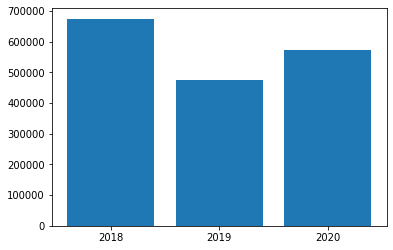

   index  year           계       증가량
1    289  2018  23202555.0  674260.0
2    289  2019  23677366.0  474811.0
3    289  2020  24250946.0  573580.0


In [90]:
bar_chart = car_year_status_df[['year','계']]

# 이상한 인덱스가 들어가서, 인덱스 재 설정 
bar_chart.reset_index(drop=False, inplace=True)

bar_chart['증가량'] = 0

for i in range(1, len(bar_chart)):
    bar_chart.loc[i,'증가량'] = bar_chart.loc[i,'계'] - bar_chart.loc[i - 1,'계']

plt.bar(bar_chart.year[1:], bar_chart.증가량[1:])
plt.show()
print(bar_chart[1:])

차량 증가 동향을 보면, 2018년에 67만건, 2019년에는 그보다 감소한 47만 5천건, 2020년 10월 기준 57만 3580건에 해당함을 알수 있다.

## [시각화 자료 1-2] 최근 3개년 자동차 증가 동향 (친환경차의 비율)

In [131]:
car_year_status_df = car_list_df[(car_list_df['연료별'] != '총계') & ((car_list_df['month'] == '12') | ((car_list_df['year'] == '2020') & (car_list_df['month'] == '10'))) ]
car_year_status_df

,연료별,시도별,합계,서울,부산,대구,인천,광주,대전,울산,...,충남,전북,전남,경북,경남,제주,계,year,month,친환경
17,휘발유,소계,계,1600270.0,635449.0,551665.0,673739.0,285769.0,320134.0,275208.0,...,452965.0,358368.0,367161.0,597237.0,777981.0,205253.0,10369752.0,2017,12,비친환경
34,경유,소계,계,1135239.0,535827.0,458852.0,656260.0,262201.0,253864.0,221735.0,...,497950.0,422783.0,499841.0,638956.0,717127.0,215321.0,9576395.0,2017,12,비친환경
51,엘피지,소계,계,301546.0,125327.0,122326.0,145392.0,87891.0,72792.0,40227.0,...,88184.0,96526.0,107845.0,132454.0,145109.0,63027.0,2104675.0,2017,12,비친환경
68,등유,소계,계,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2017,12,비친환경
85,전기,소계,계,4797.0,816.0,2005.0,542.0,548.0,303.0,356.0,...,336.0,336.0,960.0,756.0,1022.0,9206.0,25108.0,2017,12,친환경
102,알코올,소계,계,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2017,12,비친환경
119,태양열,소계,계,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2017,12,비친환경
136,CNG,소계,계,9731.0,3153.0,2669.0,2783.0,1477.0,1731.0,827.0,...,585.0,1073.0,1100.0,1225.0,1827.0,14.0,38918.0,2017,12,비친환경
153,LNG,소계,계,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,3.0,2017,12,비친환경
170,하이브리드(휘발유+전기),소계,계,57259.0,17175.0,15747.0,20074.0,7982.0,7731.0,6215.0,...,10728.0,8659.0,8794.0,12682.0,17109.0,6450.0,295654.0,2017,12,친환경


<B> 지역 / 년도별, 친환경 대 비 친환경 차량 표 </B>

In [132]:
car_year_status_df = car_year_status_df.groupby(['year', '친환경']).sum()
car_year_status_df

서울         부산         대구         인천        광주        대전  \
year 친환경                                                                    
2017 비친환경  3052015.0  1314286.0  1138235.0  1488756.0  639974.0  650987.0   
     친환경     64241.0    18938.0    18818.0    21563.0    9319.0    8632.0   
2018 비친환경  3039825.0  1346792.0  1150472.0  1546453.0  651797.0  658108.0   
     친환경     84826.0    24380.0    27881.0    31154.0   12519.0   11851.0   
2019 비친환경  3017101.0  1363163.0  1152810.0  1592302.0  659968.0  658160.0   
     친환경    107056.0    32020.0    37344.0    43021.0   16313.0   15739.0   
2020 비친환경  3021015.0  1381929.0  1171065.0  1612444.0  669762.0  663642.0   
     친환경    132717.0    41286.0    44924.0    58573.0   20204.0   21184.0   

                 울산        세종         경기        강원        충북         충남  \
year 친환경                                                                  
2017 비친환경  542273.0  126807.0  5299407.0  736493.0  778079.0  1045678.0   
     친환경     7216.0    2901.0    86615.0    9466.0    9109.0    11894.0   
2018 비친환경  548533.0  143383.0  5499265.0  753689.0  802179.0  1077775.0   
     친환경     9573.0    4486.0   118346.0   12685.0   12519.0    15863.0   
2019 비친환경  552461.0  156932.0  5612191.0  766199.0  821077.0  1097086.0   
     친환경    13178.0    6407.0   153501.0   16501.0   16525.0    21031.0   
2020 비친환경  556886.0  163533.0  5767853.0  783975.0  840696.0  1117967.0   
     친환경    16962.0    8258.0   195505.0   21222.0   21464.0    27318.0   

                 전북         전남         경북         경남        제주           계  
year 친환경                                                                    
2017 비친환경  882270.0   983622.0  1377590.0  1648469.0  484220.0  22189161.0  
     친환경     9848.0    10696.0    14561.0    19340.0   15977.0    339134.0  
2018 비친환경  902888.0  1017971.0  1402667.0  1669976.0  529049.0  22740822.0  
     친환경    13056.0    14103.0    19490.0    24472.0   24529.0    461733.0  
2019 비친환경  912353.0  1037759.0  1420683.0  1690294.0  565779.0  23076318.0  
     친환경    16708.0    18480.0    25579.0    31209.0   30436.0    601048.0  
2020 비친환경  923625.0  1064602.0  1437484.0  1721576.0  586429.0  23484483.0  
     친환경    21528.0    24728.0    31892.0    41075.0   37623.0    766463.0

In [133]:
car_year_status_df.reset_index(level=['year','친환경'], inplace = True)
car_year_status_df

,year,친환경,서울,부산,대구,인천,광주,대전,울산,세종,경기,강원,충북,충남,전북,전남,경북,경남,제주,계
0,2017,비친환경,3052015.0,1314286.0,1138235.0,1488756.0,639974.0,650987.0,542273.0,126807.0,5299407.0,736493.0,778079.0,1045678.0,882270.0,983622.0,1377590.0,1648469.0,484220.0,22189161.0
1,2017,친환경,64241.0,18938.0,18818.0,21563.0,9319.0,8632.0,7216.0,2901.0,86615.0,9466.0,9109.0,11894.0,9848.0,10696.0,14561.0,19340.0,15977.0,339134.0
2,2018,비친환경,3039825.0,1346792.0,1150472.0,1546453.0,651797.0,658108.0,548533.0,143383.0,5499265.0,753689.0,802179.0,1077775.0,902888.0,1017971.0,1402667.0,1669976.0,529049.0,22740822.0
3,2018,친환경,84826.0,24380.0,27881.0,31154.0,12519.0,11851.0,9573.0,4486.0,118346.0,12685.0,12519.0,15863.0,13056.0,14103.0,19490.0,24472.0,24529.0,461733.0
4,2019,비친환경,3017101.0,1363163.0,1152810.0,1592302.0,659968.0,658160.0,552461.0,156932.0,5612191.0,766199.0,821077.0,1097086.0,912353.0,1037759.0,1420683.0,1690294.0,565779.0,23076318.0
5,2019,친환경,107056.0,32020.0,37344.0,43021.0,16313.0,15739.0,13178.0,6407.0,153501.0,16501.0,16525.0,21031.0,16708.0,18480.0,25579.0,31209.0,30436.0,601048.0
6,2020,비친환경,3021015.0,1381929.0,1171065.0,1612444.0,669762.0,663642.0,556886.0,163533.0,5767853.0,783975.0,840696.0,1117967.0,923625.0,1064602.0,1437484.0,1721576.0,586429.0,23484483.0
7,2020,친환경,132717.0,41286.0,44924.0,58573.0,20204.0,21184.0,16962.0,8258.0,195505.0,21222.0,21464.0,27318.0,21528.0,24728.0,31892.0,41075.0,37623.0,766463.0


In [137]:
year_lst = list(set(car_year_status_df['year']))
year_lst.sort()
eco_lst = list()
not_eco_lst = list()

for year in year_lst:
    tmp = car_year_status_df[car_year_status_df['year'] == year]
    for i in tmp.index:
        if tmp.loc[i,'친환경'] == '친환경':
            eco_lst.append(tmp.loc[i,'계'])
        else:
            not_eco_lst.append(tmp.loc[i,'계'])

tmp = list()
for i in range(1, len(eco_lst)):
    tmp.append(eco_lst[i] - eco_lst[i - 1])
eco_lst = tmp

tmp = list()
for i in range(1, len(not_eco_lst)):
    tmp.append(not_eco_lst[i] - not_eco_lst[i - 1])
not_eco_lst = tmp

year_lst = year_lst[1:]
            
print(year_lst)
print(eco_lst)
print(not_eco_lst)

['2018', '2019', '2020']
[122599.0, 139315.0, 165415.0]
[551661.0, 335496.0, 408165.0]


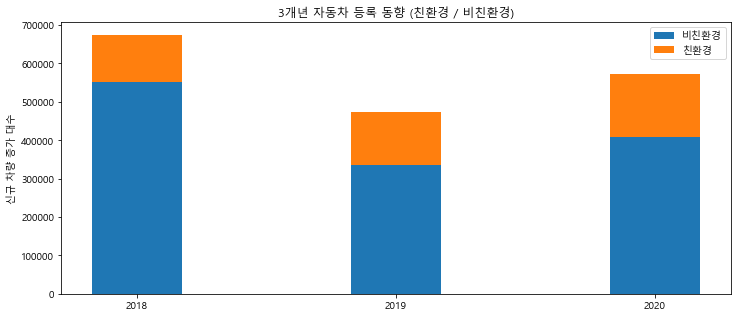

In [140]:
width = 0.35 

fix, ax = plt.subplots(1, 1, figsize=(12, 5))

ax.bar(year_lst, not_eco_lst, width, label='비친환경')
ax.bar(year_lst, eco_lst, width, label='친환경', bottom=not_eco_lst)

ax.set_ylabel('신규 차량 증가 대수')
ax.set_title('3개년 자동차 등록 동향 (친환경 / 비친환경)')
ax.legend()

plt.show()


## [시각화 자료 1-3] 최근 3개년 증가 차량중 친환경 차의 비율

[18.18274849464598, 29.341148372720937, 28.839045991840717]


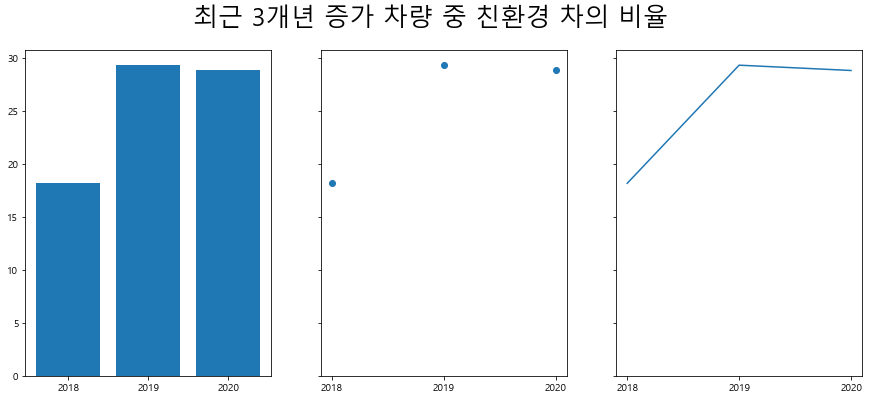

In [160]:
per_lst = list()

for i in range(len(eco_lst)):
    per_lst.append( eco_lst[i] / (eco_lst[i] + not_eco_lst[i]) * 100 )
    
fig, axs = plt.subplots(1, 3, figsize=(15, 6), sharey=True)
axs[0].bar(year_lst, per_lst)
axs[1].scatter(year_lst, per_lst)
axs[2].plot(year_lst, per_lst)
fig.suptitle('최근 3개년 증가 차량 중 친환경 차의 비율', fontsize = 25)

print(per_lst)

2019년 이후 증가 차량의 대략 30% 수준으로 친환경 차량을 등록 하는 것으로 판단할수 있음

## [시각화 자료 1-4] 최근 3개년 증가 차량중 친환경차 대비 수소 차량의 비율

In [158]:
car_year_status_df = car_list_df[(car_list_df['친환경'] == '친환경') & (car_list_df['연료별'] != '총계') & ((car_list_df['month'] == '12') | ((car_list_df['year'] == '2020') & (car_list_df['month'] == '10'))) ]
car_year_status_df.head(2)

,연료별,시도별,합계,서울,부산,대구,인천,광주,대전,울산,...,충남,전북,전남,경북,경남,제주,계,year,month,친환경
85,전기,소계,계,4797.0,816.0,2005.0,542.0,548.0,303.0,356.0,...,336.0,336.0,960.0,756.0,1022.0,9206.0,25108.0,2017,12,친환경
170,하이브리드(휘발유+전기),소계,계,57259.0,17175.0,15747.0,20074.0,7982.0,7731.0,6215.0,...,10728.0,8659.0,8794.0,12682.0,17109.0,6450.0,295654.0,2017,12,친환경


In [177]:
H_car = car_year_status_df[car_year_status_df['연료별'] == '수소'][['year', '계']]
H_car.reset_index(drop=False, inplace=True)
#non_H_car = car_year_status_df[car_year_status_df['연료별'] != '수소']

tmp = list()
for i in range(1, len(H_car)):
    tmp.append(H_car.loc[i,'계'] - H_car.loc[i - 1,'계'])
H_car = tmp

H_car

[723.0, 4190.0, 4958.0]

[0.5897274855422965, 3.007572766751606, 2.9973097965722575]


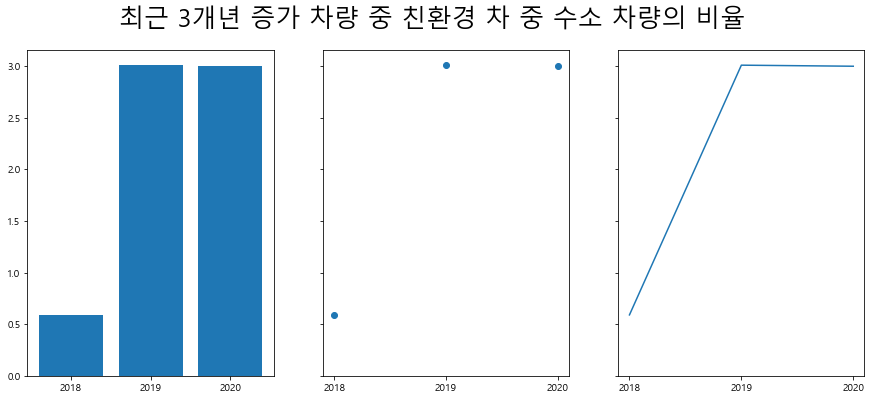

In [178]:
per_lst = list()

for i in range(len(eco_lst)):
    per_lst.append( (H_car[i] / eco_lst[i]) * 100 )
    
fig, axs = plt.subplots(1, 3, figsize=(15, 6), sharey=True)
axs[0].bar(year_lst, per_lst)
axs[1].scatter(year_lst, per_lst)
axs[2].plot(year_lst, per_lst)
fig.suptitle('최근 3개년 증가 차량 중 친환경 차 중 수소 차량의 비율', fontsize = 25)

print(per_lst)

 친환경 차량 중 3 % 수준으로 등록되고 있음을 알수 있다. 
 
 친환경 차량의 구매 대수는 지속적으로 늘어나고 있으나, 수소차량의 구매 비율은 3% 라는 것은 어떤 점에서 어려움을 겪고 있을까?

[723.0, 4190.0, 4958.0]


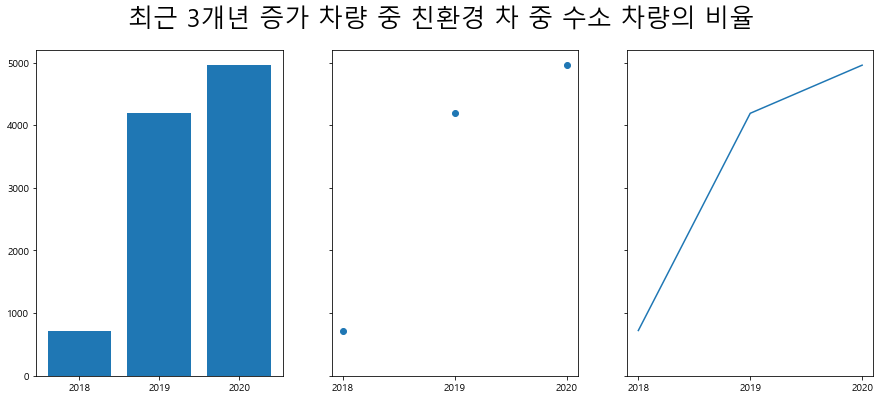

In [364]:
fig, axs = plt.subplots(1, 3, figsize=(15, 6), sharey=True)
axs[0].bar(year_lst, H_car)
axs[1].scatter(year_lst, H_car)
axs[2].plot(year_lst, H_car)
fig.suptitle('최근 3개년 증가한 수소 차량 대수 ', fontsize = 25)

print(H_car)

In [367]:
hyd_charging_df.head()

,No,충전소명,구분,공급방식,주소,충전소전화번호,용도,비고,시도,지역,위도,경도
0,1,현대자동차㈜ 환경기술연구소,저장식,튜브트레일러,경기 용인 기흥 마북로240번길 17-5(마북동),031-899-3022,연구용,NaN,경기,용인,37.307587,127.135663
1,2,한국가스공사 H2/HCNG복합충전소,제조식,개질(NG),인천 연수구 인천신항대로 960,032-810-0388,연구용,미가동,인천,인천,37.351717,126.613254
2,3,현대자동차㈜ 남양연구소,저장식,튜브트레일러,경기 화성 현대연구소로 150,NaN,연구용,NaN,경기,화성,37.159398,126.813525
3,4,에스앤디㈜-울산수소충전소,저장식,튜브트레일러,울산 남구 장생포고래로 317,052-226-6000,연구용,휴지,울산,울산,35.507446,129.383761
4,5,한국교통안전공단 자동차성능연구소,저장식,튜브트레일러,경기 화성 송산면 삼존로 200,031-369-1173,연구용,미가동,경기,화성,37.228653,126.768241


### 2.1.2 수소 자동차 충전소 (hyd_charging_df)

### [시각화 자료 1-5] 수소 충전소의 위치

In [185]:
# 지도 시작 지점을 주기 위해서
lat = hyd_charging_df['위도'].mean()
long = hyd_charging_df['경도'].mean()

m = folium.Map([lat,long], zoom_start=7)

for i in range(len(hyd_charging_df)):
    lat = hyd_charging_df.loc[i,'위도']
    loc = hyd_charging_df.loc[i,'경도']
    title = hyd_charging_df.loc[i,'충전소명']
    
    folium.Marker([lat, loc], tooltip=title).add_to(m)

# 한글 확인이 필요한 경우 아래 html 확인
m.save('hyd_charging_location.html')
m

상대적으로 서북쪽 / 서남쪽/ 동남쪽 지역에는 비교적 구축이 어느정도 되어 있으나, 동북 쪽 지역에는 한개의 충전소 외에 보이지 않는 상황이다.<p>
    
이를 토대로 시도별 충전소의 개수 나 거리에 따른 상관 관계가 있는지 확인해 보자.

#### 2.1.2.2 지역 별 충전소 개수와 차량 등록 대수의 상관 관계 

In [350]:
# 하남의 경우 경기도에 속하고 있지 않아 데이터 중간 수정
hyd_charging_df.loc[hyd_charging_df[hyd_charging_df['시도'] == '하남'].index , '시도'] ='경기'

In [351]:
location_htd_charging
location_htd_charging = hyd_charging_df.groupby('시도').count()
location_htd_charging

,No,충전소명,구분,공급방식,주소,충전소전화번호,용도,비고,지역,위도,경도
시도,,,,,,,,,,,
강원,1,1,1,1,1,1,1,0,1,1,1
경기,7,7,7,7,7,6,7,1,7,7,7
경남,6,6,6,6,6,5,6,1,6,6,6
경북,1,1,1,1,1,1,1,0,1,1,1
광주,4,4,4,4,4,3,4,1,4,4,4
대구,3,3,3,3,3,3,3,1,3,3,3
대전,1,1,1,1,1,1,1,0,1,1,1
부산,2,2,2,2,2,2,2,0,2,2,2
서울,4,4,4,4,4,4,4,1,4,4,4


In [352]:
location_htd_charging.reset_index(level=['시도'], inplace = True)

In [353]:
location_htd_charging

,시도,No,충전소명,구분,공급방식,주소,충전소전화번호,용도,비고,지역,위도,경도
0,강원,1,1,1,1,1,1,1,0,1,1,1
1,경기,7,7,7,7,7,6,7,1,7,7,7
2,경남,6,6,6,6,6,5,6,1,6,6,6
3,경북,1,1,1,1,1,1,1,0,1,1,1
4,광주,4,4,4,4,4,3,4,1,4,4,4
5,대구,3,3,3,3,3,3,3,1,3,3,3
6,대전,1,1,1,1,1,1,1,0,1,1,1
7,부산,2,2,2,2,2,2,2,0,2,2,2
8,서울,4,4,4,4,4,4,4,1,4,4,4
9,세종,1,1,1,1,1,1,1,0,1,1,1


In [354]:
df_out = car_year_status_df[car_year_status_df['연료별'] == '수소'].head(5)
df_out = df_out.transpose()
df_out.columns = ['2017', '2018', '2019', '2020']
df_out = df_out[3:21]
df_out

,2017,2018,2019,2020
서울,13,84,599,1431
부산,0,0,553,858
대구,1,2,5,61
인천,3,5,224,448
광주,36,202,488,653
대전,1,1,206,479
울산,33,345,1299,1721
세종,2,3,16,41
경기,5,7,596,1458
강원,0,0,140,821


In [355]:
df_out = pd.merge(df_out, location_htd_charging, left_index=True, right_on='시도', how='left')

In [356]:
df_out

,2017,2018,2019,2020,시도,No,충전소명,구분,공급방식,주소,충전소전화번호,용도,비고,지역,위도,경도
8.0,13,84,599,1431,서울,4.0,4.0,4.0,4.0,4.0,4.0,4.0,1.0,4.0,4.0,4.0
7.0,0,0,553,858,부산,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,2.0,2.0,2.0
5.0,1,2,5,61,대구,3.0,3.0,3.0,3.0,3.0,3.0,3.0,1.0,3.0,3.0,3.0
11.0,3,5,224,448,인천,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0
4.0,36,202,488,653,광주,4.0,4.0,4.0,4.0,4.0,3.0,4.0,1.0,4.0,4.0,4.0
6.0,1,1,206,479,대전,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
10.0,33,345,1299,1721,울산,7.0,7.0,7.0,7.0,7.0,7.0,7.0,1.0,7.0,7.0,7.0
9.0,2,3,16,41,세종,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
1.0,5,7,596,1458,경기,7.0,7.0,7.0,7.0,7.0,6.0,7.0,1.0,7.0,7.0,7.0
0.0,0,0,140,821,강원,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0


In [357]:
# 상관 계수 분석을 위해 치량 수를 숫자 형으로 변경 
df_out['2020'] = df_out['2020'].astype('float')
df_out['2019'] = df_out['2019'].astype('float')
df_out['2018'] = df_out['2018'].astype('float')
df_out['2017'] = df_out['2017'].astype('float')

#### [시각화 자료 2-1] 지역 별 충전소 개수와 차량 등록 대수의 상관 관계 

In [358]:
df_out[['2020', 'No']].corr()

,2020,No
2020,1.000000,0.719409
No,0.719409,1.000000


상관계수 확인 결과, 0.71 수준으로, 상관관계가 높다라는 것을 알수 있다.

즉, 충전소가 증가하면 구매 대수가 증가 할 가능성이 높다 라는 것을 도출해 냈다.

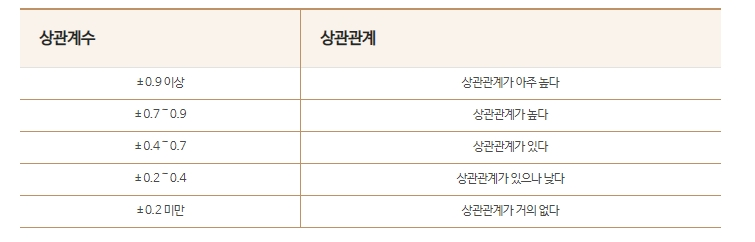

#### 2.1.2.3 수소 자동차 1대당 ,  충전소 비율 표기

In [359]:
df_out['비율'] = ( df_out['No'] / df_out['2020'])

#### [시각화 자료 2-2] 시도별 수소 자동차 1대당 충전소 비율

In [366]:
df_out.iloc[ :-2 , : ][['시도','비율']]

,시도,비율
8.0,서울,0.002795
7.0,부산,0.002331
5.0,대구,0.049180
11.0,인천,0.004464
4.0,광주,0.006126
6.0,대전,0.002088
10.0,울산,0.004067
9.0,세종,0.024390
1.0,경기,0.004801
0.0,강원,0.001218


#### [시각화 자료 2-2] 전국 수소 자동차 1대당 충전소 비율

In [361]:
df_out['No'].sum() / df_out[df_out['시도'] == '계']['2020']

NaN    0.00498
Name: 2020, dtype: float64

In [363]:
df_out[df_out['시도'] == '계']['2020'] / df_out['No'].sum()

NaN    200.82
Name: 2020, dtype: float64

### 2.1.4 전기 자동차 충전소 (elec_charging_station_df)

#### 2.1.4.1 지역 별 충전소 개수와 차량 등록 대수의 상관 관계

In [334]:
elec_corr_df = elec_charging_station_df.groupby('시도').count()
elec_corr_df

,충전소ID,충전소명,충전소주소,상세주소,위도,경도,이용가능시간,연락처,지역구분
시도,,,,,,,,,
강원,173,173,173,173,173,173,173,172,173
경기,729,729,729,724,729,729,722,729,729
경남,256,256,256,254,256,256,254,256,256
경북,204,204,204,190,204,204,190,188,204
광주,93,93,93,93,93,93,93,93,93
대구,238,238,238,226,238,238,226,229,238
대전,107,107,107,107,107,107,107,107,107
부산,137,137,137,137,137,137,137,137,137
서울,576,576,576,570,576,576,558,576,576


In [332]:
df_out = car_year_status_df[(car_year_status_df['친환경'] == '친환경') & (car_year_status_df['연료별'] != '수소')]
df_out = df_out.groupby('year').sum()
df_out = df_out.transpose()
df_out

year,2017,2018,2019,2020
서울,64228.0,84742.0,106457.0,131286.0
부산,18938.0,24380.0,31467.0,40428.0
대구,18817.0,27879.0,37339.0,44863.0
인천,21560.0,31149.0,42797.0,58125.0
광주,9283.0,12317.0,15825.0,19551.0
대전,8631.0,11850.0,15533.0,20705.0
울산,7183.0,9228.0,11879.0,15241.0
세종,2899.0,4483.0,6391.0,8217.0
경기,86610.0,118339.0,152905.0,194047.0
강원,9466.0,12685.0,16361.0,20401.0


In [335]:
df_out = pd.merge(df_out, elec_corr_df, left_index=True, right_index=True, how='left')

In [336]:
df_out

,2017,2018,2019,2020,충전소ID,충전소명,충전소주소,상세주소,위도,경도,이용가능시간,연락처,지역구분
서울,64228.0,84742.0,106457.0,131286.0,576.0,576.0,576.0,570.0,576.0,576.0,558.0,576.0,576.0
부산,18938.0,24380.0,31467.0,40428.0,137.0,137.0,137.0,137.0,137.0,137.0,137.0,137.0,137.0
대구,18817.0,27879.0,37339.0,44863.0,238.0,238.0,238.0,226.0,238.0,238.0,226.0,229.0,238.0
인천,21560.0,31149.0,42797.0,58125.0,148.0,148.0,148.0,148.0,148.0,148.0,148.0,147.0,148.0
광주,9283.0,12317.0,15825.0,19551.0,93.0,93.0,93.0,93.0,93.0,93.0,93.0,93.0,93.0
대전,8631.0,11850.0,15533.0,20705.0,107.0,107.0,107.0,107.0,107.0,107.0,107.0,107.0,107.0
울산,7183.0,9228.0,11879.0,15241.0,47.0,47.0,47.0,47.0,47.0,47.0,47.0,47.0,47.0
세종,2899.0,4483.0,6391.0,8217.0,63.0,63.0,63.0,63.0,63.0,63.0,63.0,63.0,63.0
경기,86610.0,118339.0,152905.0,194047.0,729.0,729.0,729.0,724.0,729.0,729.0,722.0,729.0,729.0
강원,9466.0,12685.0,16361.0,20401.0,173.0,173.0,173.0,173.0,173.0,173.0,173.0,172.0,173.0


In [337]:
df_out[['2020', '충전소ID']].corr()

,2020,충전소ID
2020,1.000000,0.961519
충전소ID,0.961519,1.000000


전기 자동차와 충전기의 경우 상관계수 확인 결과, 0.96 수준으로, 상관관계가 매우 높다라는 것을 알수 있다.

즉, 내 주변의 충전소가 있다면 구매 증가 할 가능성이 높다 라는 것을 두 군데 모두 확인 하였다.

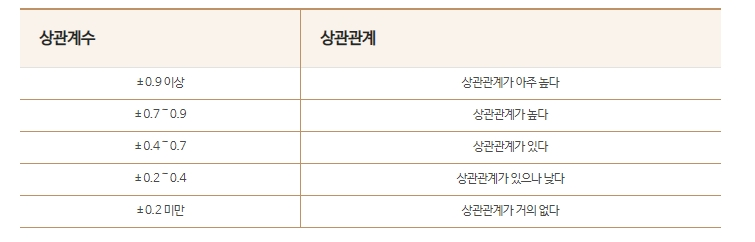

#### 2.1.2.3 전기 자동차 1대당 ,  충전소 비율 표기

In [347]:
df_out['비율'] = ( df_out['충전소ID'] / df_out['2020'])
df_out['비율']

서울    0.004387
부산    0.003389
대구    0.005305
인천    0.002546
광주    0.004757
대전    0.005168
울산    0.003084
세종    0.007667
경기    0.003757
강원    0.008480
충북    0.008130
충남    0.004353
전북    0.006939
전남    0.007514
경북    0.006400
경남    0.006365
제주    0.005422
계          NaN
Name: 비율, dtype: float64

In [348]:
df_out['충전소ID'].sum() / df_out.loc['계', '2020']

0.0047539600910602815

In [349]:
df_out.loc['계', '2020'] / df_out['충전소ID'].sum()

210.35094549499445

재밌는 사실은, 
전기차 충전소 1대당 대수와, 
수소차 충전소 1대당 대수는 거의 동일하다는 것이다.

전기차 충전소 1대는 = 210대의 전기차 수요를 이끌어 내었고,
수소차 충전소 1대는 = 201대 정도의 수소차 수요를 이끌어 냈다

정부의 2030년 목표치인 85만대를 단순 수치화 비교 한다면, 4250 개 정도의 수소차 충전소가 필요 하다. 

## 3. 데이터를 바탕으로 수소 자동차 우선 입지 선정 하기

수소자동차 우선 입지의 경우 다음과 같은 기준으로 선정한다.

기본 목표 : 정부의 2030년 85만대를 달성하기 위한 관련

1. 현재 기준 수소 충전소의 신규 설립 대수 ( 최소, 현재, 최대 )
2. 수요가 많으나 


인구 데이터 : https://kosis.kr/statHtml/statHtml.do?orgId=101&tblId=DT_1B040A3

### 아쉬운점

1. 도시 좌표를 활용하여, 떨어진 거리로 가중치를 주지 못하였다
2. 도의 경우 세부적으로 나눠서 진행하고자 했으나 